## Behavioral Cloning

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.preprocessing import image as kimage
%matplotlib inline

In [3]:
data_dir = 'data_sdc'
driving_log = pd.read_csv(data_dir + '/driving_log.csv', usecols=[0, 1, 2, 3])

In [4]:
driving_log.head()

,center,left,right,steering
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0


In [5]:
driving_log.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
steering,8036.0,0.00407,0.12884,-0.942695,0.0,0.0,0.0,1.0


(array([   13.,   495.,  7172.,   348.,     8.]),
 array([-0.9426954 , -0.55415632, -0.16561724,  0.22292184,  0.61146092,  1.        ]),
 <a list of 5 Patch objects>)

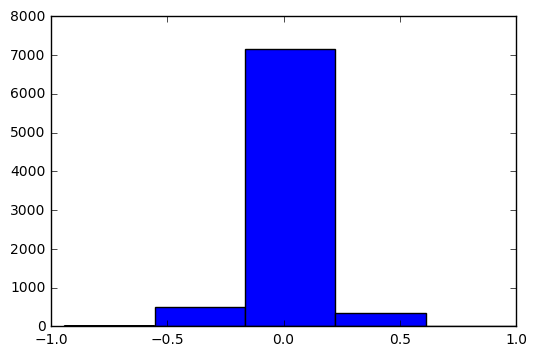

In [6]:
plt.hist(driving_log['steering'],bins = 5)

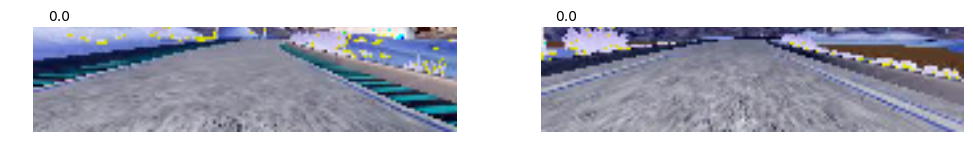

In [7]:
# Plot sample images
n_samples = 2
indexes = np.random.randint(0, len(driving_log), n_samples)
fig, axs = plt.subplots(1, n_samples)
fig.set_size_inches(12, 4)
scale = 0.5
for i,index in enumerate(indexes):
    axs[i].axis('off')
    axs[i].text(5,-3, driving_log.ix[index]['steering'])
    image = kimage.img_to_array(kimage.load_img(data_dir + "/" + driving_log.ix[index]['center'].strip(), target_size=(int(160*scale), int(320*scale))))
    image = image[int(55*scale):int(135*scale), :, :]
    axs[i].imshow(image)